# Hierarchical Time Series Forecasting

In [121]:
# Import libraries 
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pathlib import Path
from functools import reduce

from datetime import datetime
from hts import HTSRegressor
from hts.utilities.load_data import load_hierarchical_sine_data
import hts.functions
import collections
from hts.hierarchy import HierarchyTree

import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

In [11]:
# Read the data
data = pd.read_csv('data/df_final_date_wide.csv', converters={'ags2': str, 'ags5': str})
data.shape

(11228, 40)

In [20]:
# Get the relevant data
df = data[['ags2','ags5','unemployment_rate', 'date']]
df.head()

,ags2,ags5,unemployment_rate,date
0,01,01001,8.2,2019-01-01
1,01,01001,7.8,2019-02-01
2,01,01001,7.8,2019-03-01
3,01,01001,7.6,2019-04-01
4,01,01001,7.7,2019-05-01


## Create Input dataset
The next step is to create a DataFrame, which we can feed to the scikit-hts models. The DataFrame should contain each time series as a column and the rows indicate the observations in a given time period (quarter in this case).

In [35]:
# Get bottom level data - ags5
df_ags5 = df.pivot(index="date", columns="ags5", values="unemployment_rate")
print(df_ags5.shape)
df_ags5.head(10)

(28, 401)


ags5,01001,01002,01003,01004,01051,01053,01054,01055,01056,01057,...,16068,16069,16070,16071,16072,16073,16074,16075,16076,16077
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,8.2,7.9,7.8,8.3,6.4,4.9,6.3,6.3,4.8,4.7,...,6.2,3.9,5.5,4.5,4.2,5.9,4.8,5.5,5.3,8.0
2019-02-01,7.8,7.7,7.6,8.2,6.3,5.0,6.3,6.2,4.8,4.5,...,6.1,3.7,5.5,4.4,4.0,5.9,4.7,5.4,5.2,8.0
2019-03-01,7.8,7.8,7.5,8.0,6.0,4.8,5.5,5.6,4.6,4.3,...,5.7,3.4,5.3,4.2,3.7,5.7,4.4,5.2,4.9,7.6
2019-04-01,7.6,7.6,7.4,7.9,5.5,4.6,4.5,4.8,4.5,4.0,...,5.3,3.2,4.9,4.0,3.7,5.3,4.2,4.8,4.6,7.2
2019-05-01,7.7,7.7,7.3,8.0,5.2,4.6,4.2,4.5,4.5,3.9,...,5.4,3.2,4.7,3.9,3.7,5.3,4.1,4.6,4.5,7.1
2019-06-01,7.7,7.6,7.1,7.9,5.0,4.5,4.1,4.4,4.5,3.8,...,5.2,3.2,4.7,3.8,3.6,5.1,3.9,4.5,4.4,7.0
2019-07-01,8.1,7.8,7.4,8.0,5.2,4.8,4.3,4.6,4.7,4.0,...,5.2,3.3,4.8,3.9,3.7,5.2,3.9,4.5,4.5,7.0
2019-08-01,8.3,7.8,7.3,7.9,5.3,4.7,4.1,4.5,4.5,3.9,...,5.5,3.4,4.9,4.0,3.8,5.2,4.1,4.5,4.5,7.0
2019-09-01,8.3,7.4,7.1,7.6,5.1,4.6,4.0,4.3,4.3,3.8,...,5.3,3.2,4.7,3.8,3.8,4.9,3.9,4.1,4.4,6.5


In [36]:
# Get the middle level data - ags2
df_ags2 = df.groupby(["date", "ags2"]).sum().reset_index(drop=False).pivot(index="date", 
                                                                           columns="ags2", 
                                                                           values="unemployment_rate")
print(df_ags2.shape)
df_ags2.head(10)

(28, 16)


ags2,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16
date,,,,,,,,,,,,,,,,
2019-01-01,87.5,6.3,254.5,21.9,352.0,121.2,176.2,143.9,321.1,33.4,8.1,126.3,67.2,80.1,113.0,136.0
2019-02-01,85.7,6.2,250.8,21.8,349.1,120.6,174.3,140.8,315.6,33.2,7.9,125.2,66.3,79.0,111.3,133.3
2019-03-01,82.8,6.1,240.7,21.7,344.1,117.2,169.3,137.8,292.0,32.5,7.8,118.5,62.5,75.8,106.3,127.6
2019-04-01,78.7,6.0,231.8,21.5,340.9,114.1,164.4,134.8,265.7,31.9,7.7,111.8,57.2,71.2,100.0,121.2
2019-05-01,78.0,6.1,230.6,21.8,341.5,113.5,163.1,134.0,257.8,31.9,7.8,110.6,55.0,69.4,99.8,120.1
2019-06-01,76.6,6.1,227.8,21.6,340.9,111.8,163.6,133.2,253.1,31.9,7.8,108.5,53.8,67.9,97.7,117.9
2019-07-01,79.8,6.3,237.5,21.9,347.3,116.1,171.0,136.0,259.1,33.7,8.0,110.8,53.9,68.6,98.7,120.5
2019-08-01,78.9,6.3,238.8,22.2,353.0,115.7,169.6,147.3,283.3,33.5,8.0,109.0,54.1,69.6,100.0,122.5
2019-09-01,76.2,6.1,226.8,21.5,340.8,110.8,162.6,142.3,271.0,32.6,7.8,105.9,52.3,66.9,94.6,116.8


In [37]:
# Get the top level data
df_total = df.groupby("date")["unemployment_rate"].sum().to_frame().rename(columns={"unemployment_rate": "total"})
df_total

,total
date,
2019-01-01,2048.7
2019-02-01,2021.1
2019-03-01,1942.7
2019-04-01,1858.9
2019-05-01,1841.0
2019-06-01,1820.2
2019-07-01,1869.2
2019-08-01,1911.8
2019-09-01,1835.0


In [58]:
# Join the data frames
hdf = df_ags5.join(df_ags2).join(df_total)

# Set the index in datetime format
hdf.index = pd.to_datetime(hdf.index)
hdf

,01001,01002,01003,01004,01051,01053,01054,01055,01056,01057,...,08,09,10,11,12,13,14,15,16,total
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,8.2,7.9,7.8,8.3,6.4,4.9,6.3,6.3,4.8,4.7,...,143.9,321.1,33.4,8.1,126.3,67.2,80.1,113.0,136.0,2048.7
2019-02-01,7.8,7.7,7.6,8.2,6.3,5.0,6.3,6.2,4.8,4.5,...,140.8,315.6,33.2,7.9,125.2,66.3,79.0,111.3,133.3,2021.1
2019-03-01,7.8,7.8,7.5,8.0,6.0,4.8,5.5,5.6,4.6,4.3,...,137.8,292.0,32.5,7.8,118.5,62.5,75.8,106.3,127.6,1942.7
2019-04-01,7.6,7.6,7.4,7.9,5.5,4.6,4.5,4.8,4.5,4.0,...,134.8,265.7,31.9,7.7,111.8,57.2,71.2,100.0,121.2,1858.9
2019-05-01,7.7,7.7,7.3,8.0,5.2,4.6,4.2,4.5,4.5,3.9,...,134.0,257.8,31.9,7.8,110.6,55.0,69.4,99.8,120.1,1841.0
2019-06-01,7.7,7.6,7.1,7.9,5.0,4.5,4.1,4.4,4.5,3.8,...,133.2,253.1,31.9,7.8,108.5,53.8,67.9,97.7,117.9,1820.2
2019-07-01,8.1,7.8,7.4,8.0,5.2,4.8,4.3,4.6,4.7,4.0,...,136.0,259.1,33.7,8.0,110.8,53.9,68.6,98.7,120.5,1869.2
2019-08-01,8.3,7.8,7.3,7.9,5.3,4.7,4.1,4.5,4.5,3.9,...,147.3,283.3,33.5,8.0,109.0,54.1,69.6,100.0,122.5,1911.8
2019-09-01,8.3,7.4,7.1,7.6,5.1,4.6,4.0,4.3,4.3,3.8,...,142.3,271.0,32.6,7.8,105.9,52.3,66.9,94.6,116.8,1835.0


**hdf is made up of 401 kreis + 16 bundesland + 1 total = 418**

In [59]:
# Create the hierarchy indication 
hierarchy = df.groupby('ags2')['ags5'].apply(lambda x: list(set(x))).to_dict()
hierarchy

{'01': ['01053',
  '01054',
  '01058',
  '01002',
  '01060',
  '01062',
  '01004',
  '01057',
  '01059',
  '01003',
  '01056',
  '01051',
  '01061',
  '01055',
  '01001'],
 '02': ['02000'],
 '03': ['03151',
  '03461',
  '03453',
  '03103',
  '03403',
  '03155',
  '03360',
  '03401',
  '03257',
  '03458',
  '03157',
  '03352',
  '03361',
  '03101',
  '03251',
  '03452',
  '03462',
  '03153',
  '03355',
  '03459',
  '03357',
  '03154',
  '03454',
  '03354',
  '03457',
  '03460',
  '03158',
  '03451',
  '03456',
  '03359',
  '03353',
  '03159',
  '03241',
  '03455',
  '03351',
  '03254',
  '03404',
  '03255',
  '03405',
  '03402',
  '03252',
  '03356',
  '03256',
  '03358',
  '03102'],
 '04': ['04011', '04012'],
 '05': ['05915',
  '05913',
  '05315',
  '05711',
  '05162',
  '05316',
  '05120',
  '05362',
  '05122',
  '05774',
  '05914',
  '05314',
  '05334',
  '05166',
  '05154',
  '05562',
  '05124',
  '05116',
  '05515',
  '05762',
  '05119',
  '05766',
  '05513',
  '05916',
  '05954',


In [60]:
# Add total to the dictionary
hierarchy['total'] = list(hierarchy.keys())

In [61]:
# View the model Hierarchy Tree
ht = HierarchyTree.from_nodes(hierarchy, hdf)
ht

- total
   |- 01
   |  |- 01053
   |  |- 01054
   |  |- 01058
   |  |- 01002
   |  |- 01060
   |  |- 01062
   |  |- 01004
   |  |- 01057
   |  |- 01059
   |  |- 01003
   |  |- 01056
   |  |- 01051
   |  |- 01061
   |  |- 01055
   |  - 01001
   |- 02
   |  - 02000
   |- 03
   |  |- 03151
   |  |- 03461
   |  |- 03453
   |  |- 03103
   |  |- 03403
   |  |- 03155
   |  |- 03360
   |  |- 03401
   |  |- 03257
   |  |- 03458
   |  |- 03157
   |  |- 03352
   |  |- 03361
   |  |- 03101
   |  |- 03251
   |  |- 03452
   |  |- 03462
   |  |- 03153
   |  |- 03355
   |  |- 03459
   |  |- 03357
   |  |- 03154
   |  |- 03454
   |  |- 03354
   |  |- 03457
   |  |- 03460
   |  |- 03158
   |  |- 03451
   |  |- 03456
   |  |- 03359
   |  |- 03353
   |  |- 03159
   |  |- 03241
   |  |- 03455
   |  |- 03351
   |  |- 03254
   |  |- 03404
   |  |- 03255
   |  |- 03405
   |  |- 03402
   |  |- 03252
   |  |- 03356
   |  |- 03256
   |  |- 03358
   |  - 03102
   |- 04
   |  |- 04011
   |  - 04012
   |- 05
   |  

### Visualisation of the data

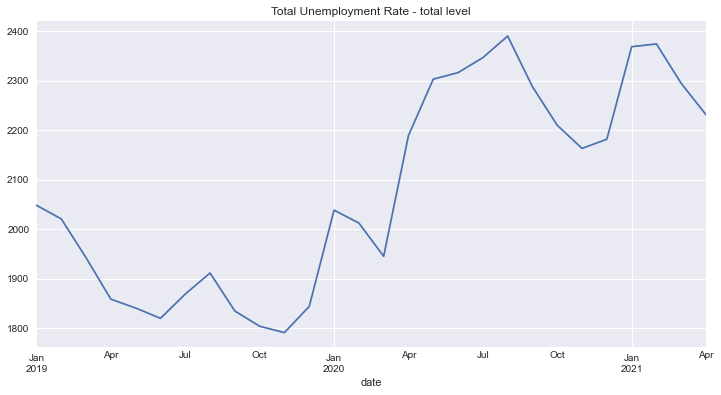

In [65]:
# Plot the total rate
hdf["total"].plot(title="Total Unemployment Rate - total level");

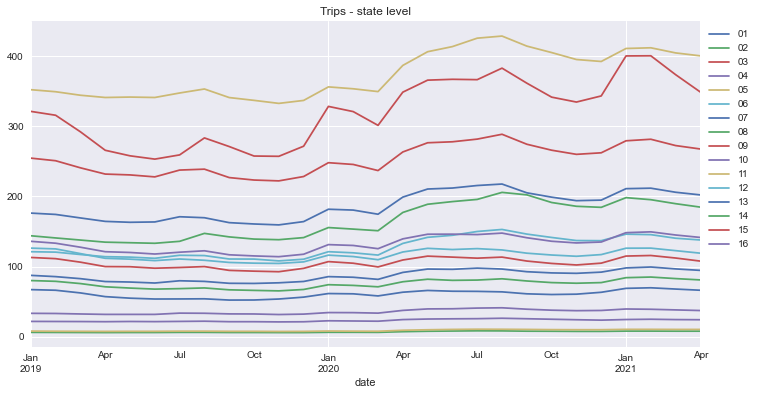

In [66]:
# Plot the state wise rate
ax = hdf[hierarchy['total']].plot(title="Trips - state level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

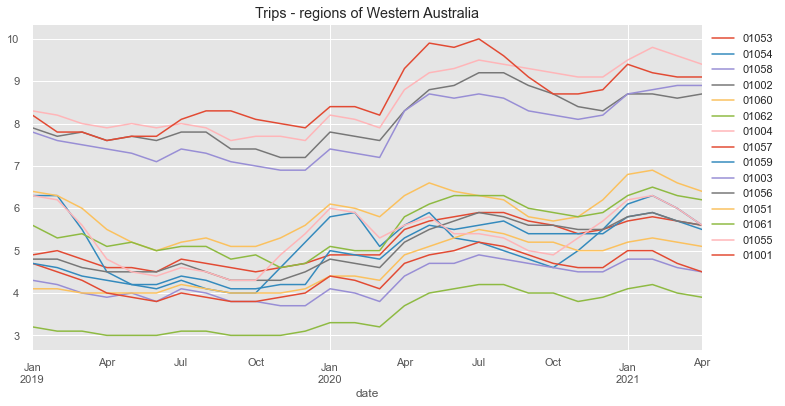

In [74]:
# plot for all kreis in one Bundesland
ax = hdf[hierarchy['01']].plot(title="Trips - regions of Western Australia")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## Forecasting

Entire data set for training and then forecast 3 steps (a year) into the future.

In [87]:
# Divide train and test data
train_hdf = hdf[:'2021-01-01']
test_hdf = hdf['2021-02-01':]
train_hdf.shape, test_hdf.shape

((25, 418), (3, 418))

In [88]:
# Model - Auto Arima
model_bu_arima = hts.HTSRegressor(model='sarimax', revision_method='BU', n_jobs=0)
model_bu_arima = model_bu_arima.fit(train_hdf, hierarchy)
pred_bu_arima = model_bu_arima.predict(steps_ahead=3)

Fitting models: 100%|███████████████████████████████████████████████████████████████| 418/418 [00:01<00:00, 211.32it/s]


In [89]:
pred_bu_arima

,total,01,02,03,04,05,06,07,08,09,...,16056,16066,16063,16054,16067,16064,16070,16071,16068,16051
2019-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-02-01,2046.048967,201.981532,200.505577,130.682796,161.243412,220.022031,163.877266,148.060164,337.323873,213.717154,...,6.891577,4.394230,4.192982,5.495305,5.395251,7.492908,5.494857,4.494462,6.192493,5.993179
2019-03-01,2018.487933,198.984979,197.708443,128.985210,158.845696,217.424265,162.778291,145.962079,331.440379,209.522589,...,6.691821,4.194492,4.093149,5.295476,5.395251,7.393003,5.494857,4.394585,6.092614,6.192951
2019-04-01,1940.247343,191.793226,190.815750,125.089531,152.753512,209.731222,160.480413,141.767902,307.034690,203.131070,...,6.591944,3.994754,3.993316,5.295476,5.195427,7.093286,5.295044,4.194831,5.693099,5.893292
2019-05-01,1856.632317,183.902410,182.924073,119.895925,144.565577,201.837938,159.281347,136.675258,279.646627,195.641101,...,6.392188,3.695148,3.793650,5.195561,5.095515,6.693665,4.895418,3.995077,5.293583,5.793406
2019-06-01,1838.781193,182.503796,182.024905,118.597629,141.969363,200.639045,160.380797,135.877043,271.878514,194.542927,...,6.292310,3.695148,3.893483,4.795903,4.995603,6.693665,4.695605,3.895200,5.393462,5.693520
2019-07-01,1818.013550,180.605950,179.027941,117.199003,140.471019,197.841286,160.080683,134.278708,266.893657,192.245835,...,6.492066,3.595279,3.793650,4.795903,4.895691,6.593759,4.695605,3.795323,5.193704,5.493747
2019-08-01,1866.948700,184.101963,182.324816,119.196894,143.368226,201.637802,163.577798,139.773452,272.975780,195.341228,...,6.591944,3.894885,3.893483,4.895817,5.095515,6.793570,4.795512,3.895200,5.193704,5.693520
2019-09-01,1909.458951,187.696791,185.521342,120.296086,144.168316,201.637161,166.374982,138.974629,297.306877,207.423271,...,6.691821,3.994754,4.093149,4.795903,5.095515,6.893476,4.895418,3.995077,5.493341,5.793406
2019-10-01,1832.764110,179.405598,176.430103,116.300232,139.673089,195.042652,161.378925,134.179081,284.344889,199.134688,...,6.292310,3.994754,3.893483,4.695988,4.895691,6.593759,4.695605,3.795323,5.293583,5.593634


In [96]:
# Final data 
test_hdf['pred'] = pred_bu_arima['2021-01-02':]['total']
test_hdf[['pred', 'total']]

,pred,total
date,,
2021-02-01,NaN,2374.7
2021-03-01,NaN,2294.9
2021-04-01,NaN,2231.5


In [95]:
pred_bu_arima['2021-01-02':]['total']

2021-01-02    2365.971478
2021-01-03    2362.850426
2021-01-04    2359.736806
Name: total, dtype: float64

In [97]:
test_hdf['total']

date
2021-02-01    2374.7
2021-03-01    2294.9
2021-04-01    2231.5
Name: total, dtype: float64

## ML Flow Experiment and testing

## Creating new data

In [215]:
d1 = pd.read_csv('data/Alo_Quote.txt', converters={'ags5':str})

In [216]:
d1.head()

,Unnamed: 0,ags5,time_stamp,value
0,0,01001,2007-05-31,12.7
1,1,01001,2007-06-30,12.2
2,2,01001,2007-07-31,12.5
3,3,01001,2007-08-31,12.3
4,4,01001,2007-09-30,11.7


In [217]:
d1.tail()

,Unnamed: 0,ags5,time_stamp,value
67765,67765,16077,2021-02-28,7.3
67766,67766,16077,2021-03-31,7.2
67767,67767,16077,2021-04-30,6.9
67768,67768,16077,2021-05-31,6.7
67769,67769,prakhar,2021-05-31,6.7


In [218]:
d1.drop([67769], axis=0, inplace=True)
d1.drop(['Unnamed: 0'], axis=1, inplace=True)

In [219]:
# Set columns
d1.columns = ['ags5', 'date', 'unemployment_rate']

In [220]:
d1

,ags5,date,unemployment_rate
0,01001,2007-05-31,12.7
1,01001,2007-06-30,12.2
2,01001,2007-07-31,12.5
3,01001,2007-08-31,12.3
4,01001,2007-09-30,11.7
...,...,...,...
67764,16077,2021-01-31,7.3
67765,16077,2021-02-28,7.3
67766,16077,2021-03-31,7.2
67767,16077,2021-04-30,6.9


In [221]:
d1['date'] = pd.to_datetime(d1['date'])
# d1.drop(['date'], axis=1, inplace=True)

In [222]:
d1['year'] = d1['date'].dt.year
d1['month'] = d1['date'].dt.month

In [223]:
df_final = d1[(d1['year'] >= 2010) & (d1['year'] < 2020)] 

In [224]:
df_final.drop(['year', 'month'], axis=1, inplace=True)
df_final

,ags5,date,unemployment_rate
32,01001,2010-01-31,13.7
33,01001,2010-02-28,14.1
34,01001,2010-03-31,13.6
35,01001,2010-04-30,13.1
36,01001,2010-05-31,12.5
...,...,...,...
67747,16077,2019-08-31,7.0
67748,16077,2019-09-30,6.5
67749,16077,2019-10-31,6.5
67750,16077,2019-11-30,6.3


In [225]:
df_final.to_csv('data/data_from_2010_to_2019_unemployment_rate.csv', index=False)

In [226]:
df_final.dtypes

ags5                         object
date                 datetime64[ns]
unemployment_rate           float64
dtype: object